In [2]:
import guitarpro
import dadagp as dada
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [4]:
DADAGP_PATH = "acdc_ex.txt"
GP_PATH = "test_acdc.gp5"
PREFIX = "./test_loops_out/acdc_test"

In [12]:
song = guitarpro.parse(GP_PATH) #check if one time signature throughout, calculate min/max beat lengths based on it
for measure in song.tracks[0].measures[0:10]:
    print(measure.timeSignature.numerator, measure.timeSignature.denominator.value)
    print(measure.keySignature) #doesn't seem like this is accurate, just defaulting to CMaj. Could we auto extract key?
#what to do if time signature changes? could just use most prominent? or split up song?

4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor
4 4
KeySignature.CMajor


In [152]:
def convert_from_dadagp(filename):
    text_file = open(filename, "r")
    tokens = text_file.read().split("\n")
    song = dada.tokens2guitarpro(tokens, verbose=False)
    song.artist = tokens[0]
    song.album = 'Generated by DadaGP'
    song.title = "untitled"
    return song

In [153]:
class MelodyNote:
    def __init__(self, duration, start, bar_start, note_list):
        self.duration = duration.value
        self.is_dotted = duration.isDotted
        self.tick_duration = 3840.0 / self.duration #3840 ticks in whole note
        if self.is_dotted:
            self.tick_duration = self.tick_duration * 1.5
        
        self.start_time = start
        self.on_bar = False
        if self.start_time == bar_start:
            self.on_bar = True

        self.notes = ["0:0"]
        self.note_types = [guitarpro.NoteType.rest]
        if len(note_list) > 0: #not a rest
            self.notes = set([f"{n.string}:{n.value}" for n in note_list])
            self.note_types = set([n.type for n in note_list])

    def __str__(self):
        return f"{self.duration} {self.is_dotted} {self.notes} {self.note_types} at {self.start_time}"
    
    def __eq__(self, other):
        if self.duration != other.duration:
            return False
        if self.is_dotted != other.is_dotted:
            return False
        
        if len(self.notes) != len(other.notes):
            return False
        for m in self.notes:
            if m not in other.notes:
                return False
        
        return True
    
def compare_patterns(p1, p2): #new pattern, existing pattern
    if len(p1) < len(p2):
        for i in range(len(p1)):
            if p1[i] != p2[i]:
                return 0 #not a substring, theres a mismatch
            return 1 #is a substring
    else:
        for i in range(len(p2)):
            if p1[i] != p2[i]:
                return 0 #not a substring, theres a mismatch
            return 2 #existing pattern is substring of the new one, replace it

def test_loop_exists(pattern_list, pattern):
    for i, pat in enumerate(pattern_list):
        result = compare_patterns(pattern, pat)
        if result == 1:
            return -1 #ignore this pattern since its a substring
        if result == 2:
            return i #replace existing pattern with this new longer one
    return None #we're just appending the new pattern

In [154]:
def create_track_list(song):
    melody_track_lists = {}
    track_names_to_id = {}
    for i, track in enumerate(song.tracks):
        melody_list = []
        for measure in track.measures:
            for beat in measure.voices[0].beats:
                note = MelodyNote(beat.duration, beat.start, measure.start, beat.notes)
                melody_list.append(note)
        melody_track_lists[track.name] = melody_list
        track_names_to_id[track.name] = i
        
    return melody_track_lists, track_names_to_id

def calc_correlation(track_list, instrument):
    melody_seq = track_list[instrument]
    corr_size = len(melody_seq)
    corr_mat = np.zeros((corr_size, corr_size), dtype='int32')
    corr_dur = np.zeros((corr_size, corr_size), dtype='float')

    for j in range(1, corr_size):
        if melody_seq[0] == melody_seq[j]:
            corr_mat[0,j] = 1
            corr_dur[0,j] = melody_seq[j].tick_duration
        else:
            corr_mat[0,j] = 0
            corr_dur[0,j] = 0
    for i in range(1, corr_size-1):
        for j in range(i+1, corr_size):
            if melody_seq[i] == melody_seq[j]:
                corr_mat[i,j] = corr_mat[i-1, j-1] + 1
                corr_dur[i, j] = corr_dur[i-1, j-1] + melody_seq[j].tick_duration
            else:
                corr_mat[i,j] = 0
                corr_dur[i,j] = 0
    
    return corr_mat, corr_dur, melody_seq

def get_valid_loops(melody_seq, corr_mat, corr_dur, min_len=4, min_beats=16.0, max_beats=32.0, min_rep_beats=4.0):
    x_num_elem, y_num_elem = np.where(corr_mat == min_len)
    #print(len(x_num_elem))

    valid_indices = []
    for i,x in enumerate(x_num_elem):
        y = y_num_elem[i]
        start_x = x - corr_mat[x,y] + 1
        start_y = y - corr_mat[x,y] + 1
        
        loop_start_time = melody_seq[start_x].start_time
        loop_end_time = melody_seq[start_y].start_time
        loop_beats = (loop_end_time - loop_start_time) / 960.0
        if loop_beats <= max_beats and loop_beats >= min_beats:
            valid_indices.append((x_num_elem[i], y_num_elem[i]))
    #print(len(valid_indices))
    
    loops = []
    loop_bp = []
    corr_size = corr_mat.shape[0]
    for start_x,start_y in valid_indices:
        x = start_x
        y = start_y
        while x+1 < corr_size and y+1 < corr_size and corr_mat[x+1,y+1] > corr_mat[x,y]:
            x = x + 1
            y = y + 1
        beginning = x - corr_mat[x,y] + 1
        duration = corr_dur[x,y] / 960.0
        end = y - corr_mat[x,y] + 1
        
        if duration >= min_rep_beats and melody_seq[beginning].on_bar:
            loop = melody_seq[beginning:end]
            exist_result = test_loop_exists(loops, loop)
            if exist_result == None:
                loops.append(loop)
                loop_bp.append((melody_seq[beginning].start_time, melody_seq[end].start_time))
            elif exist_result > 0: #index to replace
                loops[exist_result] = loop
                loop_bp[exist_result] = (melody_seq[beginning].start_time, melody_seq[end].start_time)
    #print(len(loops))
    
    return loops, loop_bp

In [155]:
def write_gp_loops(gp_filename, output_prefix, breakpoints, instrument_idx):
    for i,repeats in enumerate(breakpoints):
        print(i, repeats)
        song = guitarpro.parse(gp_filename)
        used_tracks = []
        start = repeats[0]
        end = repeats[1]
        for inst in instrument_idx:
            measures = []
            for measure in song.tracks[inst].measures:
                if measure.start >= start and measure.start < end:
                    measures.append(measure)
                else:
                    valid_beats = []
                    for beat in measure.voices[0].beats:
                        if beat.start >= start and beat.start < end:
                            valid_beats.append(beat)
                    if len(valid_beats) > 0:
                        measure.voices[0].beats = valid_beats
                        measures.append(measure)
            song.tracks[inst].measures = measures #+ measures + measures + measures
            used_tracks.append(song.tracks[inst])
            
        song.tracks = []
        for track in used_tracks:
            song.tracks.append(track)
        guitarpro.write(song, output_prefix + str(i) + ".gp5")

In [156]:
#convert_from_dadagp(DADAGP_PATH, GP_PATH)

In [157]:
track_list, track_names_to_id = create_track_list(GP_PATH)
for track in track_list.keys():
    print(f"{track}: {len(track_list[track])}")

Guitar: 708
Guitar 2: 721
Bass: 594
Piano: 488
Drums: 822


In [158]:
#TODO decide what parameters to use for training data run
#also need to automate which instrument is first in the list, could filter by guitar instruments then take loops from all guitar parts? note density?
INST = "Guitar"
MIN_LEN = 4
MIN_BEATS = 16.0
MAX_BEATS = 32.0
MIN_REP_BEATS = 4.0

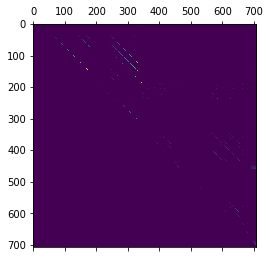

In [159]:
gtr_mat, gtr_dur, melody_seq = calc_correlation(track_list, INST)
plt.matshow(gtr_mat)

In [160]:
loop_list, loop_endpoints = get_valid_loops(melody_seq, gtr_mat, gtr_dur, min_len=MIN_LEN, min_beats=MIN_BEATS, max_beats=MAX_BEATS, min_rep_beats=MIN_REP_BEATS)
print(loop_endpoints)

[(960, 16320), (154560, 185280), (346560, 377280)]


In [161]:
write_gp_loops(GP_PATH, PREFIX, loop_endpoints, [0,1,2])

0 (960, 16320)
1 (154560, 185280)
2 (346560, 377280)


In [162]:
for i in range(len(loop_endpoints)):
    filename = PREFIX + str(i) + ".gp5"
    song = guitarpro.parse(filename)
    tokens = dada.guitarpro2tokens(song, song.artist, verbose=False)
    output_file = PREFIX + str(i) + ".txt"
    f = open(output_file, "w")
    f.write("\n".join(tokens))
    f.close()

In [165]:
FOLDER = "./generated_for_loops_c"
INST = "Guitar"
MIN_LEN = 4
MIN_BEATS = 8.0
MAX_BEATS = 32.0
MIN_REP_BEATS = 2.0

for filename in os.listdir(FOLDER):
    f_path = os.path.join(FOLDER, filename)
    track_list, track_names_to_id = create_track_list(f_path)
    gtr_mat, gtr_dur, melody_seq = calc_correlation(track_list, INST)
    loop_list, loop_endpoints = get_valid_loops(melody_seq, gtr_mat, gtr_dur, min_len=MIN_LEN, min_beats=MIN_BEATS, max_beats=MAX_BEATS, min_rep_beats=MIN_REP_BEATS)
    write_gp_loops(f_path, FOLDER + "/" + filename + "_gen_test", loop_endpoints, [0,1,2])
    #print(loop_endpoints)



0 (20160, 35520)
1 (24000, 44640)
0 (24000, 31680)
1 (47040, 75840)
0 (39360, 47040)
0 (58560, 66240)
0 (16320, 24000)
0 (16320, 31680)
1 (27840, 58560)
0 (16320, 47040)
0 (35520, 43200)


In [ ]:
track_list, track_names_to_id = create_track_list(GP_PATH)
for track in track_list.keys():
    print(f"{track}: {len(track_list[track])}")

In [1]:
import os

In [2]:
root_dir = "D:\Documents\DATA\DadaGP-Loops"

In [9]:
file_list = []
for subdir, dirs, files in os.walk(root_dir):
    short_subdir = subdir.replace(root_dir + "\\", "")
    for file in files:
        if file.endswith(".txt"):
            full_path = os.path.join(short_subdir, file)
            file_list.append(full_path)

In [ ]:
path_json = os.path.join(root_dir, "_DadaGP_LOOPS_all_filenames.json")
with open(path_json, 'w') as f:
    json.dump(file_list, f)